
### 回测说明
- 初始资金10万
- 每个交易日按前一日的双低排序，取前10支债进行轮动
- 按当日开盘价进行买卖，资金平均分配全仓买入10支可转债
- 回测用的数据是通过JQDATE提前下载好，数据截至到2021-07-31
- 没有考虑交易手续费，涨停，跌停不能购买的情况


开始日期: 2018-09-12
结束日期: 2021-07-31
总天数: 1054
初始资产: 100000
最终资产: 756904.01
收益率:656.90%
年化:101.56%


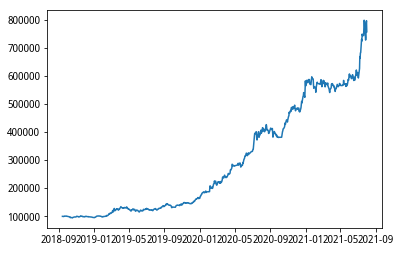

In [3]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# 选取双低转债数量
kzz_num = 10

# 总自然天数
days = 0

# 初始资金
first_cash = 100000

# 可用资金
cash = first_cash

# 单笔交易盈亏金额
profit = 0

# 当前持仓记录
stock = pd.DataFrame(data=None, index=None, columns=['code', 'qty', 'cost_price', 'amount', 'price'])

# 交易记录
trade_log = pd.DataFrame(data=None, index=None, columns=['date', 'code', 'qty', 'price', 'amount', 'profit','cash'])

# 每日市值记录
stock_log = pd.DataFrame(data=None, index=None, columns=['date', 'stock_amount', 'cash' , 'profit'])

kzz = pd.read_csv("KZZ_20210731.csv")
kzz['date'] = pd.to_datetime(kzz['date'])
# 计算双低值
kzz['double_order'] = kzz['close'] + 100 * kzz['convert_premium_rate']

kzz_price = pd.read_csv("KZZ_Price20210731.csv")
kzz_price['date'] = pd.to_datetime(kzz_price['date'])

begin = pd.to_datetime('20180912')
end = pd.to_datetime('20210731')

print('开始日期:', begin.strftime("%Y-%m-%d"))
print('结束日期:', end.strftime("%Y-%m-%d"))

# 前一天双低记录
kzz_low = pd.DataFrame

is_calc = True
last_CalcDay = ''

while begin <= end:
    print('正在计算:',begin.strftime("%Y-%m-%d") , end = '' )
    print('\r',end='')
       
    days += 1
    
    # 获取当日所有可转债价格
    kzz_day = kzz_price[kzz_price['date'] == pd.to_datetime(begin)]

    # 获取当然双低前十只
    if kzz_low.empty:
        kzz_low = kzz[(kzz['date'] == pd.to_datetime(begin)) ].sort_values(by=['double_order'], ascending=True)[:kzz_num]
        begin += datetime.timedelta(days=1)
        continue
    
    # 调用频率
    # 每天    "%Y%m%d" 
    # 每周    "%Y%W" 
    # 每月    "%Y%m" 
    tmp_str = begin.strftime("%Y%m%d")
    
    if last_CalcDay == tmp_str:
        is_calc = False
    else:
        is_calc = True  
        last_CalcDay = tmp_str

    
    if is_calc:
        # 卖出
        for row in stock.itertuples():
            stock_code = str(getattr(row, 'code'))
            cost_price = getattr(row, 'cost_price')
            stock_qty = getattr(row,'qty')        
            sell_price = cost_price

            if len(kzz_low[kzz_low['code'] == int(stock_code)]) > 0:
                continue

            # 删除持仓记录
            stock.drop(index=stock.loc[(stock['code'] == stock_code)].index, inplace=True)

            # 获取开盘价格
            if not kzz_day[kzz_day['code'] == int(stock_code)].empty:
                sell_price = float(list(kzz_day[kzz_day['code'] == int(stock_code)]['open'])[0])
                if sell_price == 0:
                    sell_price = float(list(kzz_day[kzz_day['code'] == int(stock_code)]['pre_close'])[0])                                

            # 单笔交易金额
            amount = round(sell_price * stock_qty, 2)
            profit = round((sell_price - cost_price) * stock_qty , 2)
                          
            # 增加可用现金
            cash += amount

            # 添加交易记录
            trade_log.loc[len(trade_log)] = [begin, stock_code, stock_qty * -1, sell_price,
                                             amount * -1,
                                             profit ,cash]
        # 重置持仓索引
        stock = stock.reset_index(drop=True)

        kzz_buy_num = 10 - len(stock)
        if kzz_buy_num > 0 :
            # 计算买入金额
            buy_money = cash / kzz_buy_num        
            # 买入
            for row in kzz_low.itertuples():
                low_code = str(getattr(row, 'code'))
                if len(stock[stock['code'] == low_code]) > 0:
                    continue

                price = getattr(row, 'close')
                # 按当日开盘价买入
                if not kzz_day[kzz_day['code'] == int(low_code)].empty:
                    price = float(list(kzz_day[kzz_day['code'] == int(low_code)]['open'])[0])
                    if price == 0:
                        price = float(list(kzz_day[kzz_day['code'] == int(low_code)]['pre_close'])[0])                    

                # 计算买入数量
                buy_qty = int(int(buy_money / price)/10) * 10 
                if buy_qty == 0:
                    #print('没有可买数量')
                    continue

                # 单笔交易金额
                amount = float(round(buy_qty * price, 2))

                # 添加持仓记录
                stock.loc[len(stock)] = [low_code, buy_qty, price, amount, price]

                # 减少可用现金
                cash -= amount

                # 添加交易记录
                trade_log.loc[len(trade_log)] = [begin, low_code, buy_qty, price, amount, 0 ,cash]

    if not kzz_day.empty:    
        # 更新持仓当日价格
        for i in range(0, len(stock)):
            stock_code = stock.at[i, 'code']
            qty = stock.at[i, 'qty']
            sell_price = 0

            if not kzz_day[kzz_day['code'] == int(stock_code)].empty:
                sell_price = float(list(kzz_day[kzz_day['code'] == int(stock_code)]['close'])[0])
            if sell_price == 0:
                sell_price = stock.at[i , 'price']
            if sell_price == 0:
                sell_price = stock.at[i , 'cost_price']
                
            stock.loc[i:i, 'price'] = round(sell_price, 3)
            stock.loc[i:i, 'amount'] = round(sell_price * qty, 2)
    
    # 更新双低结果作为下一天的提取依据
    kzz_low = kzz[(kzz['date'] == pd.to_datetime(begin)) ].sort_values(by=['double_order'], ascending=True)[:kzz_num]

    # 记录每日持仓市值和收益，方便画图
    sum_amount =  round(stock['amount'].sum(), 2)
    stock_log.loc[len(stock_log)] = [begin, sum_amount, cash , float(sum_amount + cash)]

    begin += datetime.timedelta(days=1)


print('===================================')

# 记录交易日志
trade_log.to_csv("backtest_trade_log.csv")
stock_log.to_csv("stock_log.csv")

# 计算最终持仓市值
last_amount = round(stock['amount'].sum(), 2)

profit = round(cash + last_amount, 2)
print('总天数:', days)
print('初始资产:', first_cash)
print('最终资产:', profit)
print('收益率:%.2f%%' % ((profit - first_cash) / first_cash * 100))

yy = days / 365
year_profit = ((profit / first_cash) ** (1 / yy) - 1) * 100
print('年化:%.2f%%' % year_profit)

plt.plot(stock_log['date'], stock_log['profit'])
plt.show()

